#04. PyTorch Custom Datasets


Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction. PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own custom dataset.

##What is a custom dataset?
A custom dataset is a collection of data relating to a specific problem you're working on. In essence, a custom dataset can be comprised of almost anything. For example, if we were building a food image classification app like [Nutrify](https://nutrify.app/), our custom dataset might be images of food. Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

PyTorch includes many existing functions to load in various custom datasets in the `TorchVision`, `TorchText`, `TorchAudio` and `TorchRec` domain libraries.
But sometimes these existing functions may not be enough. In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

What we're going to cover in this notebook
We're going to be applying the PyTorch Workflow we covered in notebook 01 and notebook 02 to a computer vision problem. But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images. The goal will be to load these images and then build a model to train and predict on them.

What we're going to build. We'll use `torchvision.datasets` as well as our own custom Dataset class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.


Specifically, we're going to cover:

**0. Importing PyTorch and setting up device-agnostic code**
Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.

**1. Get data**

We're going to be using our own custom dataset of pizza, steak and sushi images.

**2. Become one with the data (data preparation)**

At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have.

**3. Transforming data**

Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to transform our images so they're ready to be used with a model.

**4. Loading data with ImageFolder (option 1)**

PyTorch has many in-built data loading functions for common types of data. ImageFolder is helpful if our images are in standard image classification format.

**5. Loading image data with a custom Dataset**

What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.

**6. Other forms of transforms (data augmentation)**

Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of torchvision's in-built data augmentation functions.

**7. Model 0: TinyVGG without data augmentation**

By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model.

**8. Exploring loss curves**

Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**.

**9. Model 1: TinyVGG with data augmentation**

By now, we've tried a model without, how about we try one with data augmentation?

**10. Compare model results**

Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance.

**11. Making a prediction on a custom image**

Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image outside of our existing dataset.

#0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu124'

And now let's follow best practice and setup device-agnostic code.

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1. Get data
Machine learning is an iterative process, start small, get something working and increase when necessary. The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes, we're going to start with 3: pizza, steak and sushi. And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:


*   Original [Food101 dataset and paper website.](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)
*   `torchvision.datasets.Food101` - the version of the data we downloaded for this notebook.
*   `extras/04_custom_data_creation.ipynb` - a notebook we used to format the Food101 dataset to use for this notebook.
*   `data/pizza_steak_sushi.zip` - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

Note: The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.


In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


#2. Data preparation
This is another important step before building a model.

Before starting a project or building any kind of model, it's important to know what data you're working with. In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.

Note: The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`.


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started. These images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

While we're at it, let's setup our training and testing paths.

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#2.1 Visualize an image


*   Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in `.jpg`.
*   Pick a random image path using Python's `random.choice()`.
*   Get the image class name using `pathlib.Path.parent.stem`.
*   And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).
*   We'll then show the image and print some metadata.





Random image path: data/pizza_steak_sushi/train/steak/2087958.jpg
Image class: steak
Image height: 512
Image width: 512


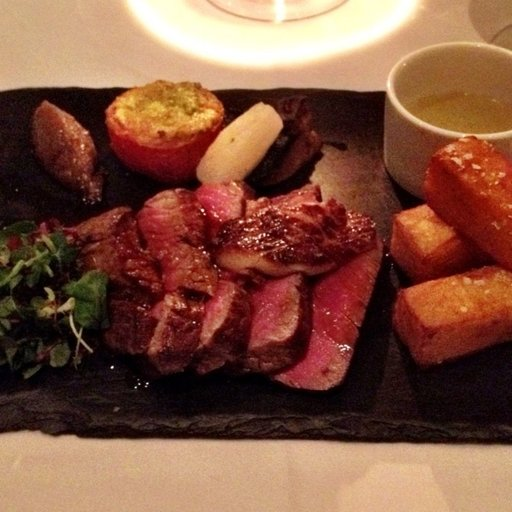

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first.

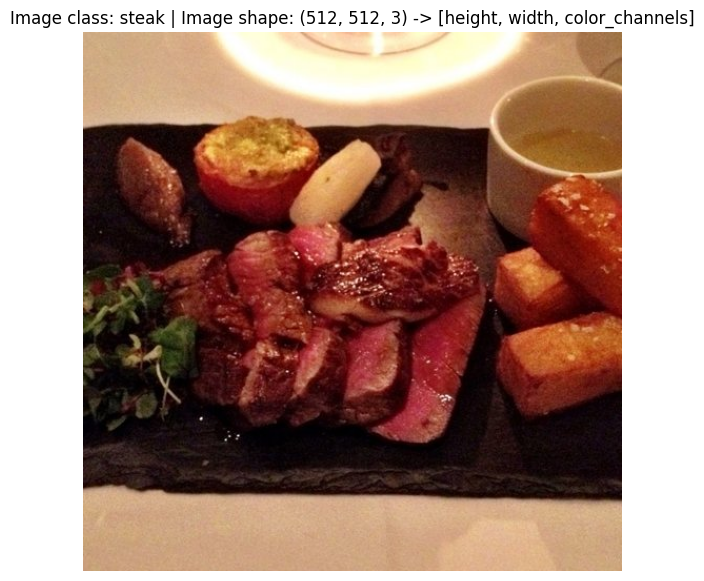

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

#3. Transforming data
Before we can use our image data with PyTorch we need to:


*   Turn it into tensors (numerical representations of our images).
*   Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

Problem space

**Vision**
Pre-built Datasets and Functions `torchvision.datasets`

**Audio**
Pre-built Datasets and Functions `torchaudio.datasets`

**Text**
Pre-built Datasets and Functions `torchtext.datasets`

**Recommendation system**
Pre-built Datasets and Functions `torchrec.datasets`


Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.

Let's import some base libraries.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#3.1 Transforming data with `torchvision.transforms`

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors. One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.
We can compile all of these steps using `torchvision.transforms.Compose()`.

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

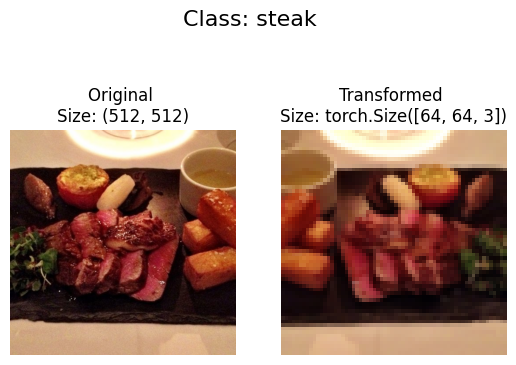

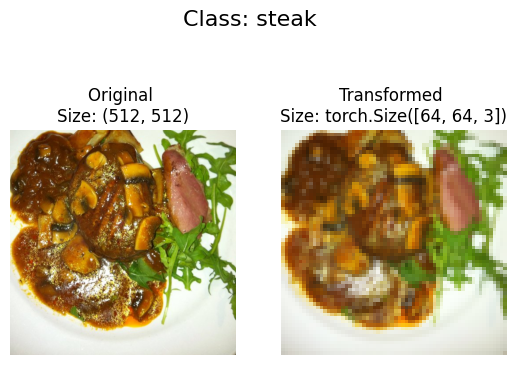

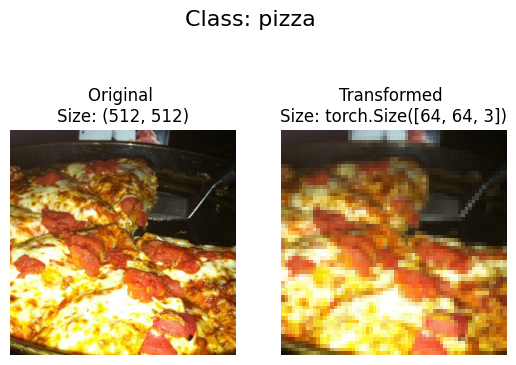

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

We've now got a way to convert our images to tensors using `torchvision.transforms`. e also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes). Generally, the larger the shape of the image, the more information a model can recover. For example, an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((256*256*3)/(64*64*3)=16). However, the tradeoff is that more pixels requires more computations.

#4. Option 1: Loading Image Data Using ImageFolder
Time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.


In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

Looks like we'll be able to use these to reference for later.
We can index on our train_data and test_data Dataset's to find samples and their target labels.

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible. Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


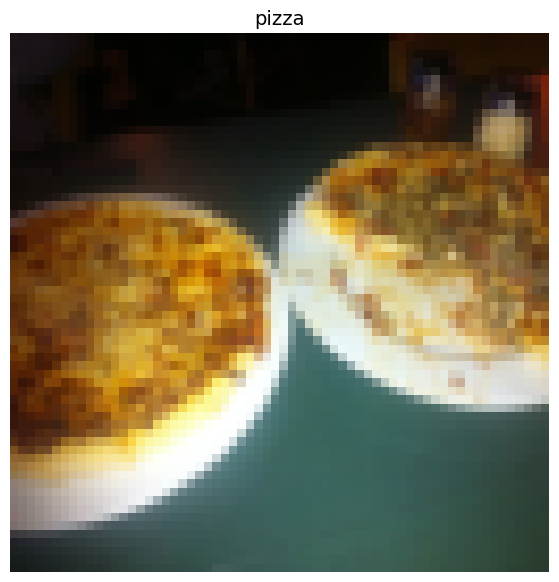

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Notice the image is now more pixelated (less quality). This is due to it being resized from 512x512 to 64x64 pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

#4.1 Turn loaded images into DataLoader's
We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s. We'll do so using `torch.utils.data.DataLoader`.

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

`num_workers` defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's `os.cpu_count()`. This ensures the `DataLoader` recruits as many cores as possible to load data.

Note: There are more parameters you can get familiar with using `torch.utils.data.DataLoader` in the [PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c1aa297cd10>,
 <torch.utils.data.dataloader.DataLoader at 0x7c1aa2c08490>)

In [19]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoader`'s with a training and testing loop to train a model. But before we do, let's look at another option to load images (or almost any other kind of data).

#5. Option 2: Loading Image Data with a Custom Dataset
What if a pre-built `Dataset` creator like `torchvision.datasets.ImageFolder()` didn't exist? Or one for your specific problem didn't exist? Well, you could build your own. But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

**Pros of creating a custom Dataset**

Can create a Dataset out of almost anything.

Not limited to PyTorch pre-built Dataset functions.

**Cons of creating a custom Dataset**

Even though you could create a Dataset out of almost anything, it doesn't mean it will work.

Using a custom Dataset often results in writing more code, which could be prone to errors or performance issues.

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:

-Python's `os` for dealing with directories (our data is stored in directories).

-Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).

-`torch` for all things PyTorch.

-PIL's `Image` class for loading images.

-`torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.

-`torchvision.transforms` to turn our images into tensors.

-Various types from Python's `typing` module to add type hints to our code.

Note: You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [21]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#5.1 Creating a helper function to get class names
Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).

3. Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#5.2 Create a custom Dataset to replicate ImageFolder

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`.

1. Subclass `torch.utils.data.Dataset`.

2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).

3. Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and `class_to_idx` (from our `find_classes()` function).

4. Create a function to load images from file and return them, this could be using PIL or `torchvision.io` (for input/output of vision data).

5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the Dataset, this is recommended but not required. This is so you can call `len(Dataset)`.

6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the Dataset, this is required.


In [25]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

A whole bunch of code to load in our images. This is one of the downsides of creating your own custom Dataset's.

However, now we've written it once, we could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on.

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x7c1aa29ba510>,
 <__main__.ImageFolderCustom at 0x7c1aa29b1650>)

In [28]:
len(train_data_custom), len(test_data_custom) #calling len() on our new Dataset's and find the classes and class_to_idx attributes.

(225, 75)

In [29]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [30]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


#5.3 Create a function to display random images

Let's create a helper function called `display_random_images()` that helps us visualize images in our `Dataset`'s.

Specifically, it'll:

1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed.

2. To prevent the display getting out of hand, we'll cap `n` at 10 images.

3. Set the random seed for reproducible plots (if `seed` is set).

4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.

5. Setup a `matplotlib` plot.

6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.

7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [32]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

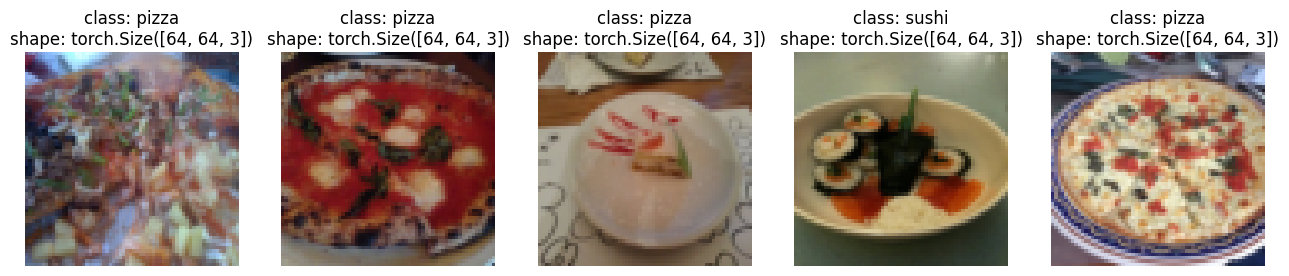

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


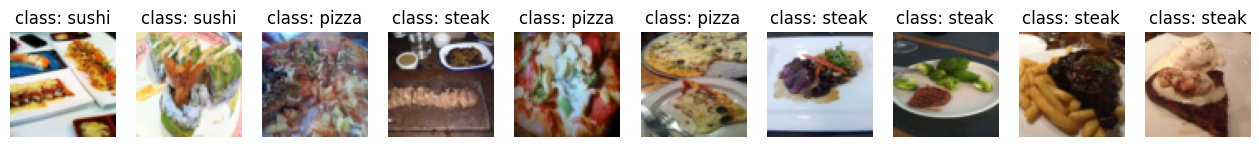

In [34]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images